/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Users/ginagrunen/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul


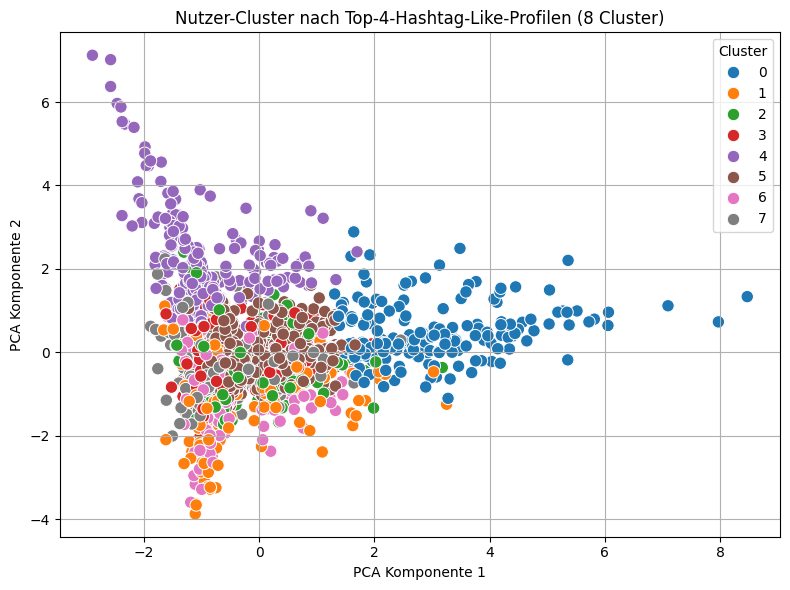


Cluster 0: Top 4 Hashtags
hashtags
#bildungfüralle    354.0
#uni               328.0
#wissen            314.0
#lernen            311.0
dtype: float64

Cluster 1: Top 4 Hashtags
hashtags
#bandlife      491.0
#vinyl          96.0
#jamsession     93.0
#beats          84.0
dtype: float64

Cluster 2: Top 4 Hashtags
hashtags
#marathon      443.0
#basketball     91.0
#fussball       81.0
#skaten         68.0
dtype: float64

Cluster 3: Top 4 Hashtags
hashtags
#wanderlust    417.0
#citytrip      220.0
#meerliebe     189.0
#abenteuer     131.0
dtype: float64

Cluster 4: Top 4 Hashtags
hashtags
#engagement       362.0
#gerechtigkeit    310.0
#klimapolitik     278.0
#wahlen           268.0
dtype: float64

Cluster 5: Top 4 Hashtags
hashtags
#fussball          227.0
#skaten            212.0
#basketball        198.0
#bildungfüralle    175.0
dtype: float64

Cluster 6: Top 4 Hashtags
hashtags
#konzert       294.0
#chor          200.0
#musikliebe    193.0
#beats         177.0
dtype: float64

Cluster 7:

In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Daten einlesen
nutzer = pd.read_csv("../Data/data_v3/Nutzer.csv")
beitraege = pd.read_csv("../Data/data_v3/Beitraege.csv")
likes = pd.read_csv("../Data/data_v3/Likes.csv")

# Schritt 1: Hashtag-Profile für alle Nutzer erstellen (nur die 4 häufigsten Hashtags pro Nutzer)
def get_user_top_hashtag_profile(user_ids, likes_df, beitraege_df, top_n=4):
    user_profiles = {}
    for uid in user_ids:
        user_likes = likes_df[likes_df['nutzer_id'] == uid]
        user_posts = beitraege_df[beitraege_df['beitrag_id'].isin(user_likes['beitrag_id'])]
        hashtags = user_posts['hashtags'].str.lower().str.replace(',', ' ').str.split().explode()
        top_hashtags = hashtags.value_counts().head(top_n)
        user_profiles[uid] = top_hashtags
    return pd.DataFrame(user_profiles).fillna(0).T

all_user_ids = nutzer['nutzer_id'].unique()
hashtag_profiles = get_user_top_hashtag_profile(all_user_ids, likes, beitraege, top_n=4)

# Schritt 2: Clustering nach Hashtag-Profilen (jetzt 8 Cluster)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
nutzer['hashtag_cluster'] = kmeans.fit_predict(hashtag_profiles)

# Schritt 3: Visualisierung mit PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hashtag_profiles)
nutzer['pca1'] = pca_result[:, 0]
nutzer['pca2'] = pca_result[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=nutzer, x='pca1', y='pca2', hue='hashtag_cluster', palette='tab10', s=80)
plt.title("Nutzer-Cluster nach Top-4-Hashtag-Like-Profilen (8 Cluster)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Schritt 4: Hashtags pro Cluster ausgeben (Top 4 pro Cluster)
for cluster in range(n_clusters):
    cluster_user_ids = nutzer[nutzer['hashtag_cluster'] == cluster]['nutzer_id']
    cluster_profile = hashtag_profiles.loc[cluster_user_ids].sum().sort_values(ascending=False)
    print(f"\nCluster {cluster}: Top 4 Hashtags")
    print(cluster_profile.head(4))


# Schritt 5: Durchschnitts-Profile ("Persona") pro Cluster berechnen und ausgeben
cluster_features = ['alter', 'geschlecht', 'region', 'politische_haltung', 'wichtigstes_wahlthema']

for cluster in range(n_clusters):
    print(f"\n--- Persona-Profil für Cluster {cluster} ---")
    cluster_nutzer = nutzer[nutzer['hashtag_cluster'] == cluster]
    # Häufigster Wert für 'alter' (Modus)
    if 'alter' in cluster_nutzer.columns:
        mode_alter = cluster_nutzer['alter'].mode()
        if not mode_alter.empty:
            print(f"Häufigstes Alter: {mode_alter.iloc[0]}")
    # Kategorische Features: Häufigster Wert (Modus)
    for feat in cluster_features:
        if feat in cluster_nutzer.columns and cluster_nutzer[feat].dtype == 'O':
            mode = cluster_nutzer[feat].mode()
            if not mode.empty:
                print(f"Häufigste(r) {feat}: {mode.iloc[0]}")
    # Hashtags der Nutzer im Cluster als Liste ausgeben (nur Top 4)
    cluster_hashtags = hashtag_profiles.loc[cluster_nutzer['nutzer_id']].sum()
    hashtags_list = cluster_hashtags[cluster_hashtags > 0].sort_values(ascending=False).index.tolist()[:4]
    print(f"Top 4 Hashtags im Cluster: {hashtags_list}")
    print(f"Anzahl Nutzer im Cluster: {len(cluster_nutzer)}")

# Schritt 6: Wähler und Nicht-Wähler pro Cluster ausgeben
print("\n--- Wähler/Nicht-Wähler pro Cluster ---")
for cluster in range(n_clusters):
    cluster_nutzer = nutzer[nutzer['hashtag_cluster'] == cluster]
    # Annahme: Spalte 'wahlfrequenz' enthält z.B. Werte wie 'immer', 'nie', 'gelegentlich'
    waehler = cluster_nutzer[cluster_nutzer['wahlfrequenz'].str.lower().isin(['immer', 'gelegentlich'])].shape[0]
    nicht_waehler = cluster_nutzer[cluster_nutzer['wahlfrequenz'].str.lower() == 'nie'].shape[0]
    print(f"Cluster {cluster}: Wähler = {waehler}, Nicht-Wähler = {nicht_waehler}, Gesamt = {len(cluster_nutzer)}")